In [1]:
from cropharvest.datasets import CropHarvest
from cropharvest.inference import Inference
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier

import requests
import tempfile

from cropharvest.datasets import Task, CropHarvest
from cropharvest.countries import get_country_bbox
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef
from typing import Dict, Optional
import pandas as pd
from typing import cast, List, Optional, Tuple, Generator
import pyproj
import rasterio
import rasterio.features
import shapely
import numpy as np
import tensorflow

np.random.seed(42)
tensorflow.random.set_seed(42)
DATA_DIR = "./data"

#!mkdir $DATA_DIR
modelo=[]
accuracy_total=[]
auc_df=pd.DataFrame()
#accuracy_matthews=[]

In [145]:
paises=['Colombia','Peru', "Argentina", "Bolivia","Ecuador"]
index_pais=[0,1,2,3,4]
my_dataset1 = CropHarvest(DATA_DIR,Task(bounding_box=get_country_bbox(paises[0])[0],normalize=True,geowiki=True))
my_dataset2 = CropHarvest(DATA_DIR,Task(bounding_box=get_country_bbox(paises[1])[0],normalize=True,geowiki=True))
my_dataset3 = CropHarvest(DATA_DIR,Task(bounding_box=get_country_bbox(paises[2])[0],normalize=True,geowiki=True))
my_dataset4 = CropHarvest(DATA_DIR,Task(bounding_box=get_country_bbox(paises[3])[0],normalize=True,geowiki=True))
my_dataset5 = CropHarvest(DATA_DIR,Task(bounding_box=get_country_bbox(paises[4])[0],normalize=True,geowiki=True))
X1, y1 = my_dataset1.as_array(flatten_x=True)
X2, y2 = my_dataset2.as_array(flatten_x=True)
X3, y3 = my_dataset3.as_array(flatten_x=True)
X4, y4 = my_dataset4.as_array(flatten_x=True)
X5, y5 = my_dataset5.as_array(flatten_x=True)

In [146]:
#Con Ecuador y división aleatoria
XTotal = np.vstack((X1,X2,X3,X4,X5))
ytotal = np.concatenate((y1,y2,y3,y4,y5))
X_trainT, X_testT, y_trainT, y_testT = train_test_split(XTotal, ytotal, test_size=0.2, random_state=42)

In [109]:
#Sin Ecuador (Se lo deja para Test)
X_trainT = np.vstack((X1,X2,X3,X4))
y_trainT = np.concatenate((y1,y2,y3,y4))
my_dataset_p = CropHarvest(DATA_DIR,Task(bounding_box=get_country_bbox("Ecuador")[0],normalize=True,geowiki=True))
X_testT,y_testT=my_dataset_p.as_array(flatten_x=True)

In [25]:
#Con Ecuador y División equitativa por países
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=42)
X_trainT = np.vstack((X_train,X_train2,X_train3,X_train4,X_train5))
X_testT = np.vstack((X_test,X_test2,X_test3,X_test4,X_test5))
y_trainT = np.concatenate((y_train,y_train2,y_train3,y_train4,y_train5))
y_testT = np.concatenate((y_test,y_test2,y_test3,y_test4,y_test5))
X_trainT.shape,X_testT.shape,y_trainT.shape,y_testT.shape

((1301, 216), (328, 216), (1301,), (328,))

In [36]:
#Con Togo Train
evaluation_datasets = CropHarvest.create_benchmark_datasets(DATA_DIR, download=False)
dataset=evaluation_datasets[2]
X_trainT,y_trainT=dataset.as_array(flatten_x=True)

In [63]:
#Solo si Test Región Andina y Train Togo
X_testT = np.vstack((X1,X2,X3,X4,X5))
y_testT = np.concatenate((y1,y2,y3,y4,y5))

### CNN 2D

In [147]:
XTotal2=X_trainT.reshape(X_trainT.shape[0], 12, 18, 1)# shape (1290, 12, 18,1)
ytotal2=y_trainT.reshape(y_trainT.shape[0], 1)#(1290, 1)
X_test2=X_testT.reshape(X_testT.shape[0], 12,18, 1)
y_test2=y_testT.reshape(y_testT.shape[0], 1)

In [148]:
def evaluate_predictions_(pais,y, preds: np.ndarray) -> Dict[str, float]:
    assert len(preds) == len(y),f"Expected preds to have length {len(y)}, got {len(preds)}"
    y_no_missing = y[y != -1]
    preds_no_missing = preds[y != -1]

    if (len(y_no_missing) == 0) or (len(np.unique(y_no_missing)) == 1):
        print(
            "This TestInstance only has one class in the ground truth "
            "or no non-missing values (this may happen if a test-instance is sliced). "
            "Metrics will be ill-defined, and should be calculated for "
            "all TestInstances together"
        )
        return {"num_samples": len(y_no_missing)}

    binary_preds = preds_no_missing > 0.5

    intersection = np.logical_and(binary_preds, y_no_missing)
    union = np.logical_or(binary_preds, y_no_missing)
    return pd.DataFrame({ 'Pais':[pais],
        "auc_roc": [roc_auc_score(y_no_missing, preds_no_missing)],
        "f1_score": [f1_score(y_no_missing, binary_preds)],
        "iou": [np.sum(intersection) / np.sum(union)],
        "num_samples": [len(y_no_missing)],
    })

In [149]:
def metrica_CNN(pais_modelo,y_test, y_pred):
  accuracy = fbeta_score(y_test, y_pred, average='micro', beta=0.5)

  #target_names = [goal+"."+label_0, goal+"."+label_1]
  cr = classification_report(y_test,y_pred)#, target_names=target_names)
  print('matthews_corrcoef',matthews_corrcoef(y_test, y_pred))
  #print('y_pred', y_pred)
  #print('y_test', y_test)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  

  results= evaluate_predictions_(pais_modelo,y_test,y_pred)
  
  print(results)

  return pais_modelo, accuracy * 100.0, cr, results,matthews_corrcoef(y_test, y_pred)

In [150]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D, MaxPooling2D,Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

def CNN_model(x1,y1,pais_modelo,x_test,y_test,lr):
    #Forma de entrada para conv1D : (batch_size,W,channels)
    #Forma de entrada para conv2D : (batch_size,(H,W),channels)
    X_train, X_val, y_train, y_val = train_test_split(x1, y1, test_size=0.2, random_state=42)
    print('modelo CNN')
    model = Sequential()
    model.add(Conv2D(64, 3, activation='relu', input_shape=(x1.shape[1], x1.shape[2],1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar y entrenar el modelo
    print('entrenar el modelo')
    
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)
    mc = ModelCheckpoint(pais_modelo+'best_model_v2.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)
    # fit model
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit( X_train, y_train,validation_data=(X_val, y_val), epochs=100, verbose=2, callbacks=[es, mc])
    print('len(X_train', len(X_train))
    print('len(X_val', len(X_val))
    print('len(X_test', len(x_test))
    # load the saved model
    saved_model = load_model(pais_modelo+'best_model_v2.h5')

    #model.fit(x1, y1, epochs=50, batch_size=32)
    
    #model.save('togo_v1.h5')
    


    y_pred_=model.predict(x_test)
    y_pred=y_pred_.reshape(y_pred_.shape[0])
    y_pred=y_pred.round()

    pais_modelo, accuracy , cr, results, mt=metrica_CNN(pais_modelo,y_test, y_pred)
    print(pais_modelo, accuracy , cr, results)
    print(results)
    print(model.summary())
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    pais_modelo, accuracy , cr, results, mt=metrica_CNN(pais_modelo,y_test, y_pred)
    print("matt coef")
    print(mt)
    return pais_modelo, accuracy , cr, results, mt

modelo CNN
entrenar el modelo
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.63516, saving model to Andinobest_model_v2.h5
33/33 - 1s - loss: 0.6730 - accuracy: 0.5797 - val_loss: 0.6352 - val_accuracy: 0.6552 - 1s/epoch - 35ms/step
Epoch 2/100


c:\Users\henry\anaconda\envs\CH38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.63516 to 0.61925, saving model to Andinobest_model_v2.h5
33/33 - 0s - loss: 0.6048 - accuracy: 0.6727 - val_loss: 0.6192 - val_accuracy: 0.6513 - 245ms/epoch - 7ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.61925 to 0.56351, saving model to Andinobest_model_v2.h5
33/33 - 0s - loss: 0.5632 - accuracy: 0.7025 - val_loss: 0.5635 - val_accuracy: 0.6935 - 245ms/epoch - 7ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.56351
33/33 - 0s - loss: 0.5455 - accuracy: 0.7313 - val_loss: 0.5732 - val_accuracy: 0.7050 - 217ms/epoch - 7ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.56351 to 0.54362, saving model to Andinobest_model_v2.h5
33/33 - 0s - loss: 0.5205 - accuracy: 0.7380 - val_loss: 0.5436 - val_accuracy: 0.6897 - 245ms/epoch - 7ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.54362 to 0.53191, saving model to Andinobest_model_v2.h5
33/33 - 0s - loss: 0.5089 - accuracy: 0.7457 - val_loss: 0.5319 - val_accuracy: 0.7318 -

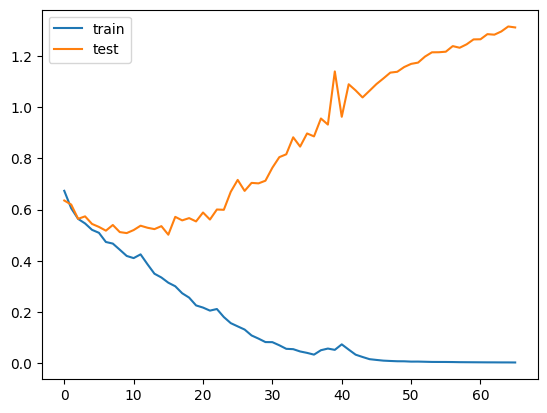

matthews_corrcoef 0.4076649945146133
Accuracy: 71.47%
     Pais   auc_roc  f1_score       iou  num_samples
0  Andino  0.702581  0.760925  0.614108          326
matt coef
0.4076649945146133


In [151]:
lr=0.001
pais_modelo_T, accuracy_T , cr_T, results_T, mt=CNN_model(XTotal2,ytotal2,"Andino",X_test2,y_testT,lr)

### CNN 1D 12_18

In [152]:
XTotal2=X_trainT.reshape(X_trainT.shape[0], 12, 18)
ytotal2=y_trainT.reshape(y_trainT.shape[0], 1)
X_test2=X_testT.reshape(X_testT.shape[0], 12, 18)
y_test2=y_testT.reshape(y_testT.shape[0], 1)
XTotal2.shape

(1303, 12, 18)

In [153]:
def evaluate_predictions_(pais,y, preds: np.ndarray) -> Dict[str, float]:
    assert len(preds) == len(y),f"Expected preds to have length {len(y)}, got {len(preds)}"
    y_no_missing = y[y != -1]
    preds_no_missing = preds[y != -1]

    if (len(y_no_missing) == 0) or (len(np.unique(y_no_missing)) == 1):
        print(
            "This TestInstance only has one class in the ground truth "
            "or no non-missing values (this may happen if a test-instance is sliced). "
            "Metrics will be ill-defined, and should be calculated for "
            "all TestInstances together"
        )
        return {"num_samples": len(y_no_missing)}

    binary_preds = preds_no_missing > 0.5

    intersection = np.logical_and(binary_preds, y_no_missing)
    union = np.logical_or(binary_preds, y_no_missing)
    return pd.DataFrame({ 'Pais':[pais],
        "auc_roc": [roc_auc_score(y_no_missing, preds_no_missing)],
        "f1_score": [f1_score(y_no_missing, binary_preds)],
        "iou": [np.sum(intersection) / np.sum(union)],
        "num_samples": [len(y_no_missing)],
    })

In [154]:
def metrica_CNN(pais_modelo,y_test, y_pred):
  accuracy = fbeta_score(y_test, y_pred, average='micro', beta=0.5)

  #target_names = [goal+"."+label_0, goal+"."+label_1]
  cr = classification_report(y_test,y_pred)#, target_names=target_names)
  print('matthews_corrcoef',matthews_corrcoef(y_test, y_pred))
  #print('y_pred', y_pred)
  #print('y_test', y_test)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  

  results= evaluate_predictions_(pais_modelo,y_test,y_pred)
  
  print(results)

  return pais_modelo, accuracy * 100.0, cr, results,matthews_corrcoef(y_test, y_pred)

In [155]:
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D, MaxPooling2D,Dropout
from keras.models import load_model
from matplotlib import pyplot


# Generar datos de ejemplo
#X_train = np.random.random((1000, 100, 1))
#y_train = np.random.randint(2, size=(1000, 1))

# Construir la arquitectura de la red CNN
def CNN_model(x1,y1,pais_modelo,x_test,y_test, lr):
    X_train, X_val, y_train, y_val = train_test_split(x1, y1, test_size=0.2, random_state=42)
    #Forma de entrada para conv1D : (batch_size,W,channels)
    #Forma de entrada para conv2D : (batch_size,(H,W),channels)
    print('modelo CNN')
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(x1.shape[1], x1.shape[2])))
    model.add(MaxPooling1D(2))
    
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar y entrenar el modelo
    print('entrenar el modelo')
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.fit(x1, y1, epochs=50, batch_size=32)
    
    #model.save('togo_v1.h5')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=30)
    mc = ModelCheckpoint(pais_modelo+'_v1_best_model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)
    # fit model
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit( X_train, y_train,validation_data=(X_val, y_val), epochs=100, verbose=2, callbacks=[es, mc])
    #history = model.fit(x1[:round(x1.shape[0]*0.75)], y1[:round(x1.shape[0]*0.75)],validation_data=(x1[round(x1.shape[0]*0.75):], y1[round(x1.shape[0]*0.75):]), epochs=100, verbose=0, callbacks=[es, mc])
    # load the saved model
    saved_model = load_model(pais_modelo+'_v1_best_model.h5')

    print('len(X_train', len(X_train))
    print('len(X_val', len(X_val))
    print('len(X_test', len(x_test))


    y_pred_=model.predict(x_test)
    y_pred=y_pred_.reshape(y_pred_.shape[0])
    y_pred=y_pred.round()

    pais_modelo, accuracy , cr, results, mt=metrica_CNN(pais_modelo,y_test, y_pred)
    print(pais_modelo, accuracy , cr, results)
    print(results)
    print(model.summary())
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    pais_modelo, accuracy , cr, results, mt=metrica_CNN(pais_modelo,y_test, y_pred)

    return pais_modelo, accuracy , cr, results, mt


In [ ]:
lr=0.001
pais_modelo_T, accuracy_T , cr_T, results_T, mt=CNN_model(XTotal2,ytotal2,"Andino",X_test2,y_testT,lr)

### CNN 1D 216

In [157]:
XTotal2=X_trainT.reshape(X_trainT.shape[0], X_trainT.shape[1], 1)# shape (1290, 216, 1)
ytotal2=y_trainT.reshape(y_trainT.shape[0], 1)#(1290, 1)
X_test2=X_testT.reshape(X_testT.shape[0], X_testT.shape[1],1)
y_test2=y_testT.reshape(y_testT.shape[0], 1)

In [158]:
def evaluate_predictions_(pais,y, preds: np.ndarray) -> Dict[str, float]:
    assert len(preds) == len(y),f"Expected preds to have length {len(y)}, got {len(preds)}"
    y_no_missing = y[y != -1]
    preds_no_missing = preds[y != -1]

    if (len(y_no_missing) == 0) or (len(np.unique(y_no_missing)) == 1):
        print(
            "This TestInstance only has one class in the ground truth "
            "or no non-missing values (this may happen if a test-instance is sliced). "
            "Metrics will be ill-defined, and should be calculated for "
            "all TestInstances together"
        )
        return {"num_samples": len(y_no_missing)}

    binary_preds = preds_no_missing > 0.5

    intersection = np.logical_and(binary_preds, y_no_missing)
    union = np.logical_or(binary_preds, y_no_missing)
    return pd.DataFrame({ 'Pais':[pais],
        "auc_roc": [roc_auc_score(y_no_missing, preds_no_missing)],
        "f1_score": [f1_score(y_no_missing, binary_preds)],
        "iou": [np.sum(intersection) / np.sum(union)],
        "num_samples": [len(y_no_missing)],
    })

In [159]:
def metrica_CNN(pais_modelo,y_test, y_pred):
  accuracy = fbeta_score(y_test, y_pred, average='micro', beta=0.5)

  #target_names = [goal+"."+label_0, goal+"."+label_1]
  cr = classification_report(y_test,y_pred)#, target_names=target_names)
  print('matthews_corrcoef',matthews_corrcoef(y_test, y_pred))
  #print('y_pred', y_pred)
  #print('y_test', y_test)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  

  results= evaluate_predictions_(pais_modelo,y_test,y_pred)
  
  print(results)

  return pais_modelo, accuracy * 100.0, cr, results

In [160]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D, MaxPooling2D, Dropout
from keras.models import load_model
from matplotlib import pyplot

# Generar datos de ejemplo
#X_train = np.random.random((1000, 100, 1))
#y_train = np.random.randint(2, size=(1000, 1))

# Construir la arquitectura de la red CNN
def CNN_model(x1,y1,pais_modelo,x_test,y_test, lr):
    X_train, X_val, y_train, y_val = train_test_split(x1, y1, test_size=0.2, random_state=42)

    #Forma de entrada para conv1D : (batch_size,W,channels)
    #Forma de entrada para conv2D : (batch_size,(H,W),channels)
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(x1.shape[1], 1)))
    model.add(MaxPooling1D(2))
    
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compilar y entrenar el modelo
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20)
    mc = ModelCheckpoint(pais_modelo+'_v0_best_model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)
    # fit model

    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    #history = model.fit(x1[:round(x1.shape[0]*0.75)], y1[:round(x1.shape[0]*0.75)],validation_data=(x1[round(x1.shape[0]*0.75):], y1[round(x1.shape[0]*0.75):]), epochs=100, verbose=0, callbacks=[es, mc])
    history = model.fit( X_train, y_train,validation_data=(X_val, y_val), epochs=100, verbose=2, callbacks=[es, mc])
    # load the saved model
    saved_model = load_model(pais_modelo+'_v0_best_model.h5')

    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.fit(x1, y1, epochs=100, batch_size=32)

    y_pred=model.predict(x_test)
    y_pred=y_pred.reshape(y_pred.shape[0])
    y_pred=y_pred.round()

    print(model.summary())
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.show()


    pais_modelo, accuracy , cr, results=metrica_CNN(pais_modelo,y_test, y_pred)

    return pais_modelo, accuracy , cr, results

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.61263, saving model to Andino_v0_best_model.h5
33/33 - 1s - loss: 0.6522 - accuracy: 0.6046 - val_loss: 0.6126 - val_accuracy: 0.6858 - 1s/epoch - 42ms/step
Epoch 2/100


c:\Users\henry\anaconda\envs\CH38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.61263 to 0.60596, saving model to Andino_v0_best_model.h5
33/33 - 0s - loss: 0.5601 - accuracy: 0.7111 - val_loss: 0.6060 - val_accuracy: 0.6513 - 379ms/epoch - 11ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.60596 to 0.53825, saving model to Andino_v0_best_model.h5
33/33 - 0s - loss: 0.5237 - accuracy: 0.7351 - val_loss: 0.5382 - val_accuracy: 0.7318 - 411ms/epoch - 12ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.53825
33/33 - 0s - loss: 0.4981 - accuracy: 0.7390 - val_loss: 0.5667 - val_accuracy: 0.6858 - 468ms/epoch - 14ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.53825 to 0.50490, saving model to Andino_v0_best_model.h5
33/33 - 0s - loss: 0.4737 - accuracy: 0.7601 - val_loss: 0.5049 - val_accuracy: 0.7433 - 414ms/epoch - 13ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.50490
33/33 - 0s - loss: 0.4619 - accuracy: 0.7678 - val_loss: 0.5079 - val_accuracy: 0.7433 - 382ms/epoch - 12ms/step
Epoch 7/100


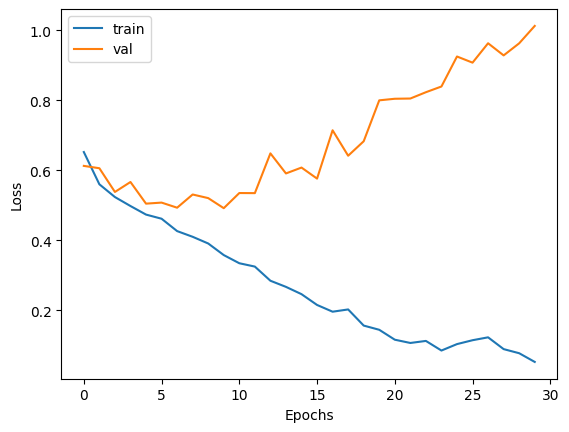

matthews_corrcoef 0.4048164349915919
Accuracy: 70.86%
     Pais   auc_roc  f1_score       iou  num_samples
0  Andino  0.704136  0.746667  0.595745          326


In [163]:
lr=0.001
pais_modelo_T, accuracy_T , cr_T, results_T=CNN_model(XTotal2,ytotal2,"Andino",X_test2,y_testT,lr)

### Random Forest

In [79]:
def evaluate_predictions_funcion(pais,y, preds: np.ndarray) -> Dict[str, float]:
    assert len(preds) == len(y),f"Expected preds to have length {len(y)}, got {len(preds)}"
    y_no_missing = y[y != -1]
    preds_no_missing = preds[y != -1]

    if (len(y_no_missing) == 0) or (len(np.unique(y_no_missing)) == 1):
        print(
            "This TestInstance only has one class in the ground truth "
            "or no non-missing values (this may happen if a test-instance is sliced). "
            "Metrics will be ill-defined, and should be calculated for "
            "all TestInstances together"
        )
        return {"num_samples": len(y_no_missing)}

    binary_preds = preds_no_missing > 0.5

    intersection = np.logical_and(binary_preds, y_no_missing)
    union = np.logical_or(binary_preds, y_no_missing)
    return pd.DataFrame({ 'Pais':[pais],
        "auc_roc": [roc_auc_score(y_no_missing, preds_no_missing)],
        "f1_score": [f1_score(y_no_missing, binary_preds)],
        "iou": [np.sum(intersection) / np.sum(union)],
        "num_samples": [len(y_no_missing)],
    })

In [80]:
def datos_XT_solo(B,C,index_B):
  

  model = RandomForestClassifier(random_state=0)
  model.fit(B, C)

  y_pred = model.predict(X_testT)
  accuracy = fbeta_score(y_testT, y_pred, average='micro', beta=0.5)

  #target_names = [goal+"."+label_0, goal+"."+label_1]
  cr = classification_report(y_testT,y_pred)#, target_names=target_names)
  print('matthews_corrcoef',matthews_corrcoef(y_testT, y_pred))
  print('y_pred', y_pred)
  print('y_test', y_testT)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  
  pais_modelo=[]
  for i in index_B:
    #print(i)
    pais_modelo.append(paises[i])
    print(paises[i])
    #paises[0:1]
  print('aqui')
  results= evaluate_predictions_funcion(pais_modelo,y_testT,y_pred)
  print(results)
  return pais_modelo, accuracy * 100.0, cr, results

In [81]:
pais_modelo,accuracy_, cr_T, aucr=datos_XT_solo(X_trainT,y_trainT,index_pais[:-1])
auc_df=aucr
modelo.append(pais_modelo)
accuracy_total.append(accuracy_)
print(cr_T)

matthews_corrcoef 0.10298534373971896
y_pred [1 0 1 ... 0 0 0]
y_test [1 1 1 ... 0 0 0]
Accuracy: 50.15%
Colombia
Peru
Argentina
Bolivia
aqui
                                   Pais   auc_roc  f1_score     iou  \
0  [Colombia, Peru, Argentina, Bolivia]  0.544178  0.386707  0.2397   

   num_samples  
0         1629  
              precision    recall  f1-score   support

           0       0.45      0.82      0.58       687
           1       0.67      0.27      0.39       942

    accuracy                           0.50      1629
   macro avg       0.56      0.54      0.48      1629
weighted avg       0.58      0.50      0.47      1629

